## Stage 0: Initialize settings

In [1]:
!nvidia-smi

Thu Mar 11 20:46:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
basePath = '/content/drive/Shareddrives/cs273ASharedDrive/project'

Mounted at /content/drive/


In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import sys
import os
import time

import seaborn as sns
from collections import Counter
import random

In [4]:
## Sets the seed for generating random numbers
# Setting the random seed manually --> garantee each time has the same result of randomization.
torch.manual_seed(0)

## Detect GPU and Set up device
use_gpu = True
use_cuda = use_gpu and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Models are trained on: GPU" if use_cuda else "Models are trained on: CPU")


Models are trained on: GPU


## Step 1: Extract data records from dataset CIFAR10

In [5]:
augment = True

if (augment):
  transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    #torchvision.transforms.Resize((64,64)),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=Image.BILINEAR)
  ])
else:
  transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [6]:
trainset = torchvision.datasets.CIFAR10(root=basePath+'/data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root=basePath+'/data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Step 2: Use PyTorch dataloader to load the data records for the Target Model

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


In [8]:
targetDataLoader = {"train": trainloader, "val": testloader}
targetDatasetSizes = {"train": len(trainset), "val": len(testset)}

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def showDataset(num):
  visualLoader = torch.utils.data.DataLoader(trainset, batch_size=num,
                                            shuffle=True, num_workers=2)

  # get some random training images
  dataiter = iter(visualLoader)
  images, labels = dataiter.next()

  # show images
  imshow(torchvision.utils.make_grid(images))
  # print labels
  print('  '.join('%8s' % classes[labels[j]] for j in range(num)))

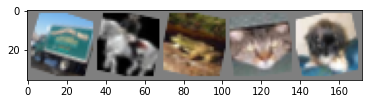

   truck     horse      frog       cat       dog


In [10]:
showDataset(5)

## Step 3: Define & Load Network Architecture

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
def Net_cifar10_ResNet():
    return ResNet(ResidualBlock)

In [13]:
# Select the model based on the configuration 
modelType = "ResNet"
if modelType == "ResNet":
    Net_cifar10 = Net_cifar10_ResNet
#if modelType == "CNN3":
#    Net_cifar10 = Net_cifar10_CNN3
#if modelType == "CNN2":
#    Net_cifar10 = Net_cifar10_CNN2
    
## move the model to the computing device(GPU/CPU)
targetModel = Net_cifar10().to(device)

## Step 4: Define loss function, optimizer, and learning rate scheduler

In [14]:
import torch.optim as optim
from torch.optim import lr_scheduler # learning rate stragegy

In [15]:
# since we are classifying images into more than two classes 
# we will use cross-entropy as a loss function.
criterion = nn.CrossEntropyLoss()

# to optimize the network we will employ 
# stochastic gradient descent (SGD) with momentum to 
# help get us over local minima and saddle points in the loss function space.
optimizer = optim.SGD(targetModel.parameters(),
                      lr = 0.0001,
                      momentum = 0.5)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=30,
                                       gamma=0.9)

## Step 5: Train & Test the Target Model

In [16]:
import copy
from torchvision import datasets, models

def trainModel(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, numberOfEpochs=25):
    since = time.time() # record the starting time
    modelWeights = copy.deepcopy(model.state_dict())
    accuracy = 0
    trainingRecord = np.zeros((4,numberOfEpochs)) # Record the accuracy and loss v.s. epoches in training and test
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(numberOfEpochs):
        # Initialize lists
        PredictionVectors = [] # the output of the model
        InOrOutLabel = [] # Whether this instance comes from the training set 
        Class = [] # instance predicted label
        predLabel = [] # test set's predicted label
        actualLabel = [] # test set's ground truth label

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer.step()
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            # Initialize records of the losses and the number of correct predictions
            runLoss = 0.0
            runCorrects = 0
            # Iterate over data.
            for batch_idx, (data, target) in enumerate( dataloaders[phase]):
                inputs, labels = data.to(device), target.to(device)
                optimizer.zero_grad() # initialize --> set the gradients to be zero
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # forward propagation
                    # choose the class with the largest probability as the predicted label
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    # at the final epoch, evaluate the result
                    if epoch == numberOfEpochs-1:
                        for output in outputs.cpu().detach().numpy():
                            # put all the instances' prediction vector in a list
                            PredictionVectors.append(output)
                            if phase == "train":
                                InOrOutLabel.append(1) # 1 stands for being in the training set
                            else:
                                InOrOutLabel.append(0) # 0 stands for not being in the training set
                        for category in labels.cpu().detach().numpy():
                            Class.append(category)
                        # on the test set, record the predictions and truth labels 
                        if phase == 'val':
                            for predition in preds.cpu().detach().numpy():
                                predLabel.append(predition)
                            for label in labels.cpu().detach().numpy():
                                actualLabel.append(label)
                    # on the training set, backward propagate and optimize the model's parameters.
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # summarize and update loss and accuracy at the end of each batch
                runLoss += loss.item() * inputs.size(0)
                runCorrects += torch.sum(preds == labels.data)
            # summarize the loss and the accuracy at the end of each epoch
            epochLoss = runLoss / dataset_sizes[phase]
            epochAccuracy = runCorrects.double() / dataset_sizes[phase]
            if phase == 'train': # on the training set
                trainingRecord[0][epoch] = epochLoss
                trainingRecord[1][epoch] = epochAccuracy
            else: # on the test set
                trainingRecord[2][epoch] = epochLoss
                trainingRecord[3][epoch] = epochAccuracy
            # save the best model's parameters
            if phase == 'val' and epochAccuracy > accuracy:
                accuracy = epochAccuracy
                modelWeights = copy.deepcopy(model.state_dict())

    timeUsed = time.time() - since # calculate time used
    print('Complete training in {:.0f} minutes {:.0f} seconds'.format(timeUsed//60, timeUsed%60)) # format the time
    return model, trainingRecord, np.array(PredictionVectors), np.array(InOrOutLabel), np.array(Class), np.array(predLabel), np.array(actualLabel)

In [17]:
'''
The targetTrainingRecord consists of [loss on training set per epoch,
                                      accuracy on training set per epoch,
                                      loss on test set per epoch,
                                      accuracy on test set per epoch]
'''
targetModel, targetTrainingRecord, targetPredictionVectors, targetInOrOutLabel, \
targetClass, predLabelList, actualLabelList = trainModel(targetModel,
                                                        criterion,
                                                        optimizer,
                                                        exp_lr_scheduler,
                                                        targetDataLoader,
                                                        targetDatasetSizes,
                                                        numberOfEpochs=200)

Complete training in 236 minutes 24 seconds


## Step 6: Save result for Attack Model

In [ ]:
'''
np.savetxt(path + "/targetTrainingRecord.txt", targetTrainingRecord)
np.savetxt(path + "/targetPredictionVectors.txt", targetPredictionVectors)
np.savetxt(path + "/targetInOrOutLabel.txt", targetInOrOutLabel)
np.savetxt(path + "/targetClass.txt", targetClass)
# Use np.loadtxt to load these files into numpy

print("Final Training Loss: {}".format(targetTrainingRecord[0][-1]))
print("Final test Loss: {}".format(targetTrainingRecord[2][-1]))
print("Final Training ACC: {}".format(targetTrainingRecord[1][-1]))
print("Final test ACC: {}".format(targetTrainingRecord[3][-1]))
'''

## Step 7: Visualize some information about the result

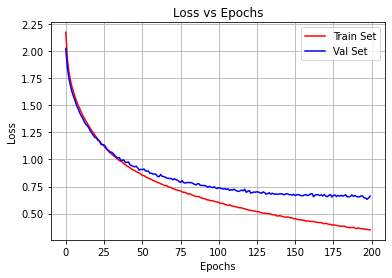

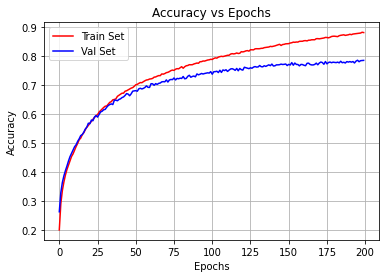

In [20]:
x = range(len(targetTrainingRecord[0]))
plt.plot(x,targetTrainingRecord[0],'-',color='r',label="Train Set")
plt.plot(x,targetTrainingRecord[2],'-',color='b',label="Val Set")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.savefig(basePath + "/LossVSEpochs.jpg")
plt.show()

plt.plot(x,targetTrainingRecord[1],'-',color='r',label="Train Set")
plt.plot(x,targetTrainingRecord[3],'-',color='b',label="Val Set")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid("both")
plt.savefig(basePath + "/AccuracyVSEpochs.jpg")
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

In [22]:

## Define the function to dram the Confusion Matrix
def plot_confusion_matrix(cm, classes, path, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path + "/CM.png")
    plt.show()

Normalized confusion matrix


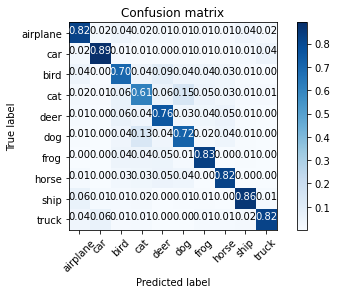

In [23]:
cm = confusion_matrix(actualLabelList, predLabelList)
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_confusion_matrix(cm=cm, classes=classes, path=basePath, normalize=True)